In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import pathlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import normalize, label_binarize
#import xgboost as xgb
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

%matplotlib inline

In [2]:
lfc_mb_filt=pd.read_csv('/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/lfc_mb_filt_07_22_24.csv')
lfc_mb_filt.head()

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,BXD73_vs_in_vitro_H37Rv,BXD73b_vs_in_vitro_H37Rv,BXD77_vs_in_vitro_H37Rv,BXD79_vs_in_vitro_H37Rv,BXD9_vs_in_vitro_H37Rv,BXD90_vs_in_vitro_H37Rv,BXD93_vs_in_vitro_H37Rv,C57BL.6J_vs_in_vitro_H37Rv,DBA.2J_vs_in_vitro_H37Rv,Functional_Category
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.48,0.00,0.00,0.00,information pathways
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,0.97,-0.19,0.05,0.59,0.04,0.13,0.33,0.43,0.32,information pathways
3,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,-0.30,-1.79,-1.34,-0.33,-1.84,-0.30,0.71,-0.27,-0.02,information pathways
4,Rv0006,0.53,0.37,-1.21,1.66,0.25,1.18,3.31,-0.10,-0.12,...,-1.10,-0.95,0.33,-0.20,-1.32,-0.35,-0.88,1.49,-1.31,information pathways


In [3]:
value_cols = [col for col in lfc_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

In [4]:
def rf_vanilla(mat, cols, norm_method, name):
    X = mat[cols].values
    y = mat['Functional_Category'].values
    n_classes = mat['Functional_Category'].nunique()
    accuracy = []
    confusion = np.zeros((n_classes, n_classes))
    skf = StratifiedKFold(n_splits=3, shuffle=True)
    y_true_all = []
    y_pred_all = []
    y_score_all = np.zeros((len(y), n_classes))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if norm_method == 'SMOTE':
            X_train, y_train = SMOTE().fit_resample(X_train, y_train)
            clf = RandomForestClassifier(n_estimators=100)
        elif norm_method == 'bal_weights':
            clf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_hat)
        y_score_all[test_index] = y_score

        confusion += confusion_matrix(y_test, y_hat)
        accuracy.append(accuracy_score(y_test, y_hat))
    
    confusion = confusion / 3
    confusion = normalize(confusion, axis=1, norm='l1')
    print(accuracy)
    
    # Create confusion matrix
    col_names = ['PE/PPE', 'cell wall and\ncell processes', 'information pathways', 'insertion seqs\nand phages',
                 'intermediary metabolism\nand respiration', 'lipid metabolism', 'regulatory proteins', 'virulence, detoxification,\nadaptation']
    confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)
    plt.figure(figsize=(7, 7))
    rc = {'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 14}
    sns.set(rc=rc)
    heat = sns.heatmap(confusion, annot=True, linewidths=.1,
                       fmt='1.2f', square=True)
    heat.set(xlabel='PREDICTED CLASS', ylabel='TRUE CLASS', title=name)

    # Compute and print additional metrics
    classes = np.unique(y)
    metrics = compute_metrics(np.array(y_true_all), np.array(y_pred_all), y_score_all, classes)
    print_metrics(metrics, "Random Forest")

    return None

In [6]:
def compute_metrics(y_true, y_pred, y_score, classes):
    # Macro-averaged F1 Score
    f1_macro = f1_score(y_true, y_pred, average='macro')
    
    # Weighted F1 Score
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_true, y_pred)
    
    # Macro-averaged AUROC
    y_true_bin = label_binarize(y_true, classes=classes)
    y_pred_bin = label_binarize(y_pred, classes=classes)
    macro_roc_auc = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
    
    return {
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted,
        'Cohen\'s Kappa': kappa,
        'Macro AUROC': macro_roc_auc
    }

def print_metrics(metrics, model_name):
    print(f"Metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    print()

[0.3023493360572012, 0.3237997957099081, 0.338100102145046]
Metrics for Random Forest:
F1 Macro: 0.2842
F1 Weighted: 0.3120
Cohen's Kappa: 0.1398
Macro AUROC: 0.4983



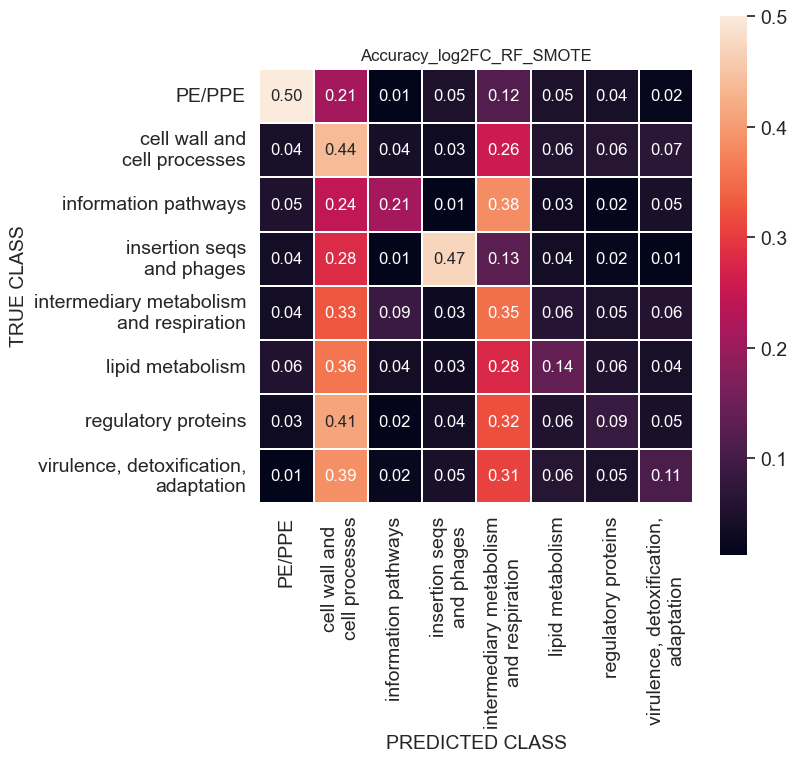

In [12]:
rf_vanilla(lfc_mb_filt, value_cols, 'SMOTE', 'Accuracy_log2FC_RF_SMOTE')

[0.3718079673135853, 0.3799795709908069, 0.372829417773238]
Metrics for Random Forest:
F1 Macro: 0.2533
F1 Weighted: 0.3193
Cohen's Kappa: 0.1271
Macro AUROC: 0.4947



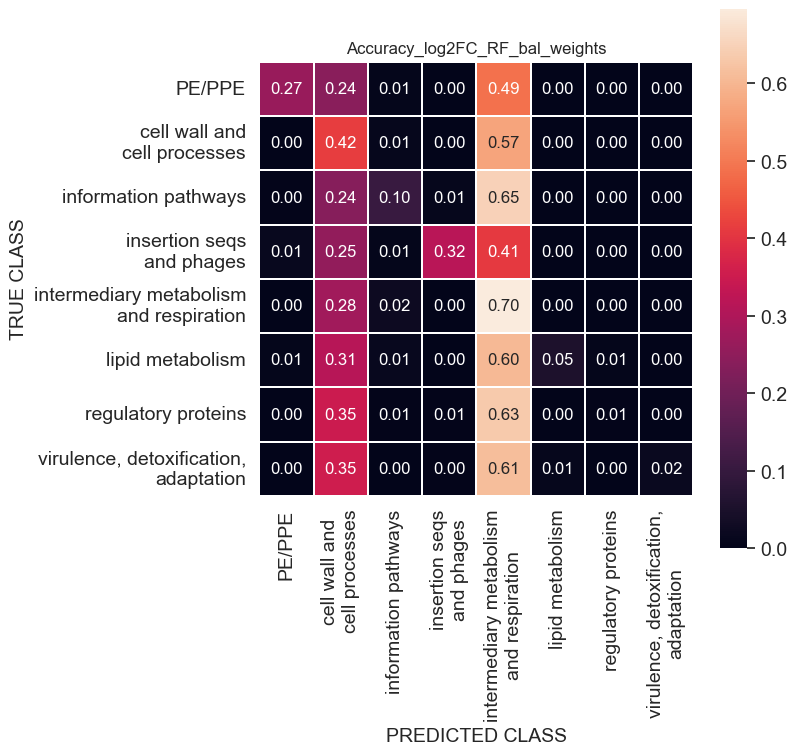

In [13]:
rf_vanilla(lfc_mb_filt, value_cols, 'bal_weights', 'Accuracy_log2FC_RF_bal_weights')

In [14]:
lfc_bin_mb_filt=pd.read_csv('/Users/amandaspencer/Documents/mtb_tn_db/data/standardized_data/cleaned_ML/bin_mb_filt.csv')
lfc_bin_mb_filt.head()

,Rv_ID,PE35_KO_vs_mbio_H37Rv,PPE68_KO_vs_mbio_H37Rv,Rv0950c_KO_vs_CB_WT,Rv0954_KO_vs_RJ_WT,Rv1096_KO_vs_CB_WT,Rv3005c_KO_day32_vs_dejesus_H37Rv_day32,Rv3594_KO_vs_Rubin_FLUTE_WT,Rv3684_KO_vs_CB_WT,Rv3717_KO_vs_Rubin_FLUTE_WT,...,BXD73_vs_in_vitro_H37Rv_bin.1,BXD73b_vs_in_vitro_H37Rv_bin.1,BXD77_vs_in_vitro_H37Rv_bin.1,BXD79_vs_in_vitro_H37Rv_bin.1,BXD90_vs_in_vitro_H37Rv_bin.1,BXD93_vs_in_vitro_H37Rv_bin.1,BXD9_vs_in_vitro_H37Rv_bin.1,C57BL.6J_vs_in_vitro_H37Rv_bin.1,DBA.2J_vs_in_vitro_H37Rv_bin.1,Functional_Category
0,Rv0001,-0.41,0.01,0.00,0.00,0.00,3.12,-0.06,0.00,-0.06,...,0,0,0,0,0,0,0,0,0,information pathways
1,Rv0002,3.28,2.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,information pathways
2,Rv0003,-0.03,-0.08,0.03,-1.20,0.39,3.83,0.31,0.17,-0.62,...,0,0,0,0,0,0,0,0,0,information pathways
3,Rv0005,-0.22,0.14,0.13,-0.08,0.27,-2.38,0.70,-0.71,-0.37,...,0,0,0,0,0,0,0,0,0,information pathways
4,Rv0006,0.53,0.37,-1.21,1.66,0.25,1.18,3.31,-0.10,-0.12,...,0,0,0,0,0,0,0,0,0,information pathways


In [15]:
value_cols_lfc_bin = [col for col in lfc_bin_mb_filt.columns if col not in ['Rv_ID', 'Functional_Category']]

[0.33401430030643514, 0.3432073544433095, 0.30337078651685395]
Metrics for Random Forest:
F1 Macro: 0.2946
F1 Weighted: 0.3206
Cohen's Kappa: 0.1480
Macro AUROC: 0.4992



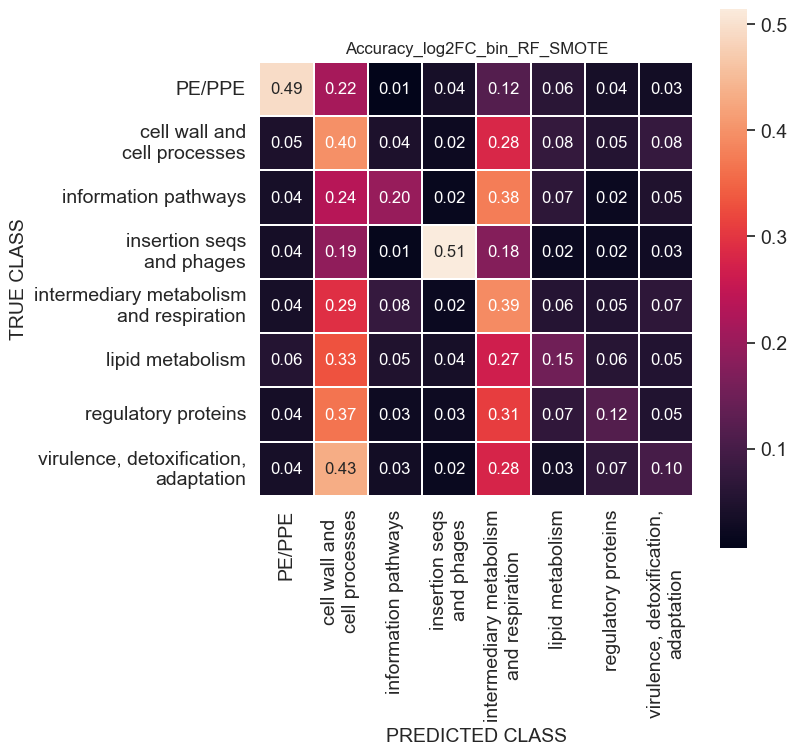

In [16]:
rf_vanilla(lfc_bin_mb_filt, value_cols_lfc_bin, 'SMOTE', 'Accuracy_log2FC_bin_RF_SMOTE')

[0.36670071501532175, 0.372829417773238, 0.36976506639427986]
Metrics for Random Forest:
F1 Macro: 0.2586
F1 Weighted: 0.3175
Cohen's Kappa: 0.1225
Macro AUROC: 0.5050



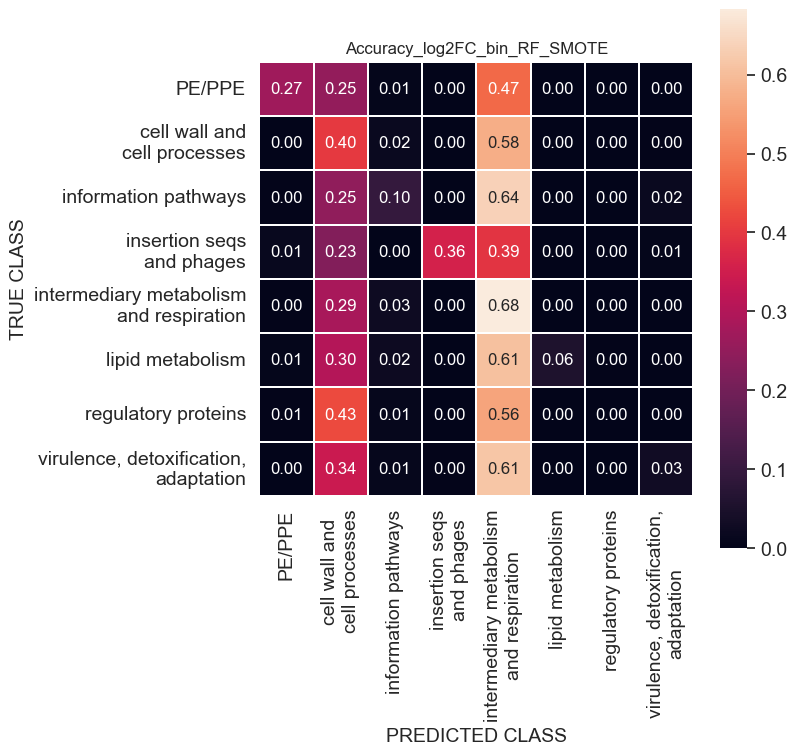

In [17]:
rf_vanilla(lfc_bin_mb_filt, value_cols_lfc_bin, 'bal_weights', 'Accuracy_log2FC_bin_RF_SMOTE')

# with umap

In [ ]:
umap_10 = pd.read_csv('../data/tests/df_umap_10.csv')
umap = pd.read_csv('../data/tests/df_umap.csv')

In [ ]:
umap = umap.drop(columns=['gene_name', 'func_tuberculist', 'COG'])
umap_10 = umap_10.drop(columns=['gene_name', 'func_tuberculist', 'COG'])

In [ ]:
lfc_umap = lfc_mb_filt.merge(umap, how='left', on='Rv_ID')
lfc_umap_10 = lfc_mb_filt.merge(umap_10, how='left', on='Rv_ID')

In [ ]:
#fill empty umaps with zero
lfc_umap = lfc_umap.fillna(0)
lfc_umap_10 = lfc_umap.fillna(0)

In [ ]:
lfc_umap_value_cols = [col for col in lfc_umap.columns if col not in ['Rv_ID', 'Functional_Category']]
rf_vanilla(lfc_umap, lfc_umap_value_cols, 'SMOTE', 'Accuracy_log2FC_umap_RF_SMOTE')

In [ ]:
lfc_umap_10_value_cols = [col for col in lfc_umap_10.columns if col not in ['Rv_ID', 'Functional_Category']]
rf_vanilla(lfc_umap_10, lfc_umap_10_value_cols, 'SMOTE', 'Accuracy_log2FC_umap_10_RF_SMOTE')